In [1]:
import math
import os
import warnings
from typing import Dict, List, Tuple

import albumentations as A
import cv2
import numpy as np
import random
import torch
import tqdm
import wandb
from PIL import Image
from torch import nn

import matplotlib.pyplot as plt
import torchmetrics
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import transforms
import albumentations.pytorch
from glob import glob
from torch.utils.data import random_split, Dataset, DataLoader
from albumentations.pytorch import ToTensorV2


#warnings.filterwarnings("ignore")

In [2]:
#%pip install supervision

В этот раз мы познакомимся с задачей детекции. Сделаем это, обучив модель YOLOv5. Это далеко не самая современная модель, но она достаточно близка к тем, которые используются сейчас.

Всего есть два типа моделей детекции: двухэтапные и одноэтапные. Несколько примеров моделей, использующих разные подходы:
- RCNN подход: Предполагает двухэтапный проход модели по изображению, где изначально выделяются зоны способами классического компьютерного зрения, а затем происходит уже знакомая нам классификация объектов в зонах и предсказание с помощью задачи регрессии координат box для объектов. 
- YOLO подход: Одноэтапный детектор удаляет процесс извлечения области интереса и напрямую классифицирует и регрессирует анкерные блоки-кандидаты (anchor-boxes). YOLO — это архитектура детекции, которая называется YOU ONLY LOOK ONCE.Она обучается от от начала до конца, для обработки изображения и прогнозирования ограничивающих рамок (BBox) и меток классов для каждой ограничивающей рамки напрямую. Наверное, наиболее популярная, также лицензия предполгает постоянное появление новых моделей
- Detr - также одноэтапный, однако использующий трансформерную архитектуру и особенный дизайн предсказывающей головы, чтобы уйти от необходимости предсказания анкерных блоков (что довольно затратно), предсказывая объекты сразу. Иронично, но в поздних версиях к анкерам вернулись.

![alt_text](../../additional_materials/images/detection_stages.jfif)



In [3]:
%pip install -r https://raw.githubusercontent.com/ultralytics/yolov5/master/requirements.txt

Note: you may need to restart the kernel to use updated packages.


Для начала посмотрим, как модель строит свои предсказания

Using cache found in /home/dima/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-11-24 Python-3.12.7 torch-2.4.1+cu121 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 
100%|██████████| 49.2k/49.2k [00:00<00:00, 1.35MB/s]
100%|██████████| 134k/134k [00:00<00:00, 1.56MB/s]
/home/dima/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:892: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
image 1/2: 720x1280 2 persons, 1 tie, 1 cell phone
image 2/2: 1080x810 4 persons, 1 bus
Speed: 8.5ms pre-process, 58.2ms inference, 2.7ms NMS per image at shape (2, 3, 640, 640)


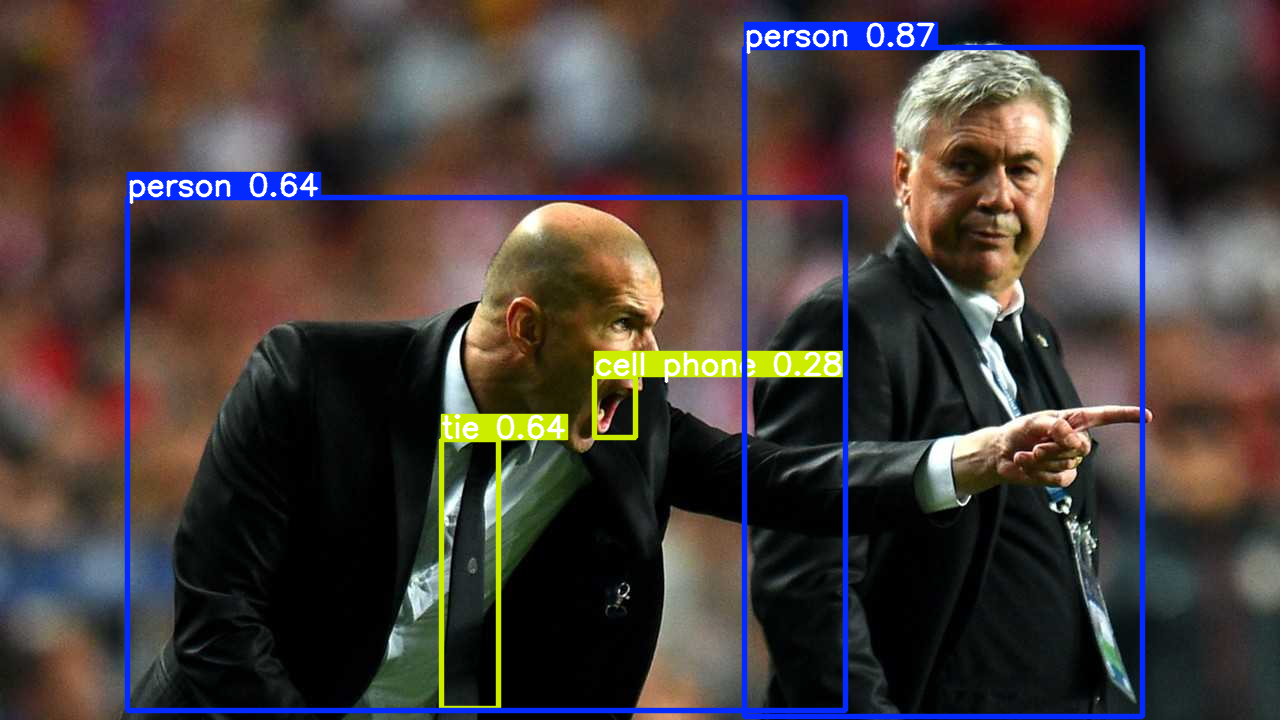

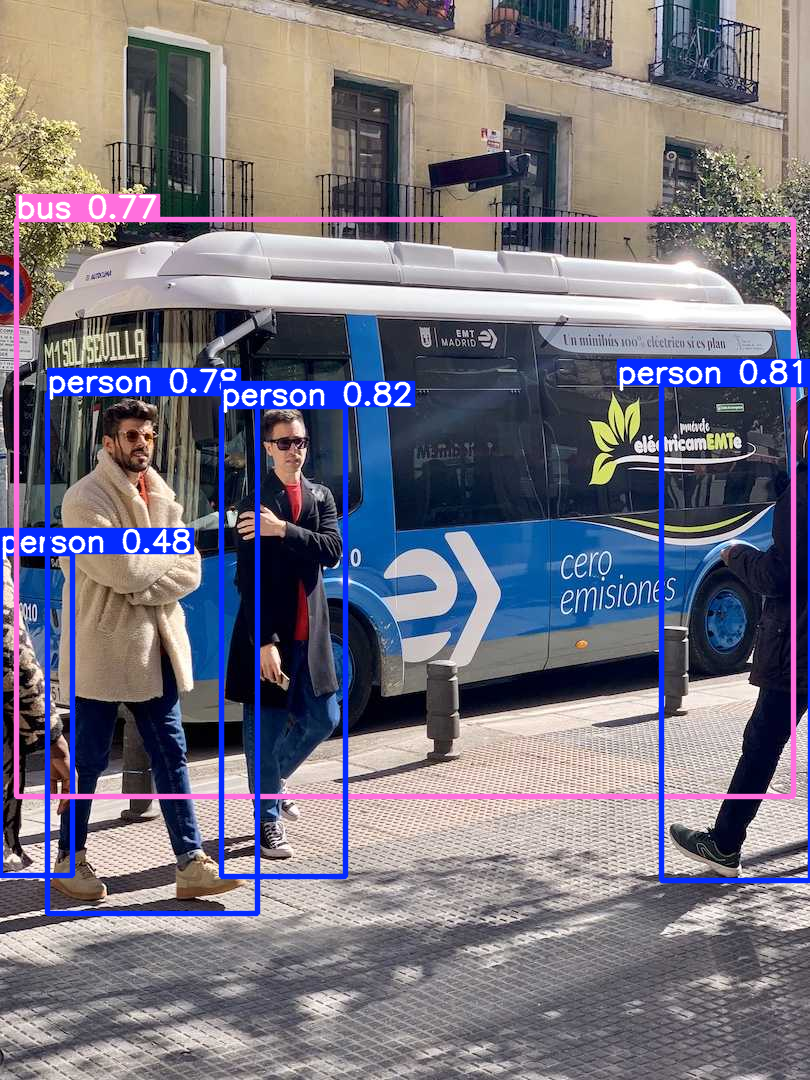

xmin        ymin         xmax        ymax  confidence  class  \
0  744.907715   47.730713  1142.076172  716.559692    0.867366      0   
1  127.860962  197.634521   845.973755  710.378174    0.637457      0   
2  441.277222  439.579590   498.367310  708.055664    0.635028     27   
3  594.006104  376.740417   635.634888  437.111267    0.277625     67   

         name  
0      person  
1      person  
2         tie  
3  cell phone

In [4]:
import torch

model = torch.hub.load("ultralytics/yolov5", "yolov5s")
im = "https://ultralytics.com/images/zidane.jpg"

for f in "zidane.jpg", "bus.jpg":
    torch.hub.download_url_to_file("https://ultralytics.com/images/" + f, f)  # download 2 images
im1 = Image.open("zidane.jpg")  # PIL image
im2 = cv2.imread("bus.jpg")[..., ::-1]  # OpenCV image (BGR to RGB)

results = model([im1, im2], size=640)  # batch of images
results.print()
results.show()

results.xyxy[0]
results.pandas().xyxy[0]

Другой способ загрузить предобученную модель - загрузить с хаба YOLO. 

In [5]:
from ultralytics import YOLO
model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)

In [6]:
results = model([im1, im2])  # batch of images
display(results[0].boxes)


0: 640x640 2 persons, 1 tie, 45.2ms
1: 640x640 4 persons, 1 bus, 45.2ms
Speed: 4.3ms preprocess, 45.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)


ultralytics.engine.results.Boxes object with attributes:

cls: tensor([ 0.,  0., 27.])
conf: tensor([0.85778, 0.78797, 0.48391])
data: tensor([[7.48790e+02, 4.13692e+01, 1.14939e+03, 7.10778e+02, 8.57784e-01, 0.00000e+00],
        [1.43081e+02, 2.00775e+02, 1.13484e+03, 7.12409e+02, 7.87974e-01, 0.00000e+00],
        [3.61049e+02, 4.38252e+02, 5.24050e+02, 7.15941e+02, 4.83914e-01, 2.70000e+01]])
id: None
is_track: False
orig_shape: (720, 1280)
shape: torch.Size([3, 6])
xywh: tensor([[949.08832, 376.07361, 400.59753, 669.40869],
        [638.96313, 456.59198, 991.76367, 511.63464],
        [442.54935, 577.09668, 163.00140, 277.68921]])
xywhn: tensor([[0.74148, 0.52232, 0.31297, 0.92973],
        [0.49919, 0.63416, 0.77482, 0.71060],
        [0.34574, 0.80152, 0.12734, 0.38568]])
xyxy: tensor([[ 748.78955,   41.36923, 1149.38708,  710.77795],
        [ 143.08130,  200.77466, 1134.84497,  712.40930],
        [ 361.04865,  438.25208,  524.05005,  715.94128]])
xyxyn: tensor([[0.58499, 0.05

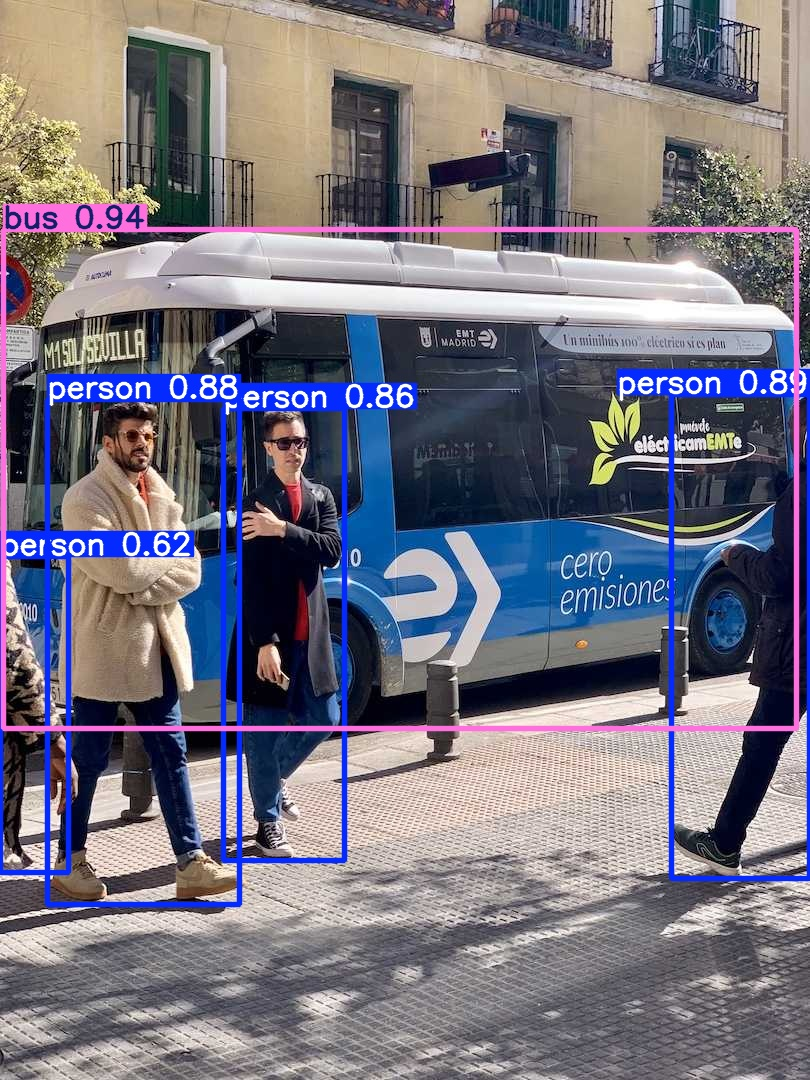

In [7]:
# Выведите новые результаты
from IPython.display import Image 
pil_img = Image(filename="./runs/detect/predict/image0.jpg")
display(pil_img)


0: 384x640 2 persons, 1 tie, 27.6ms
Speed: 0.8ms preprocess, 27.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)


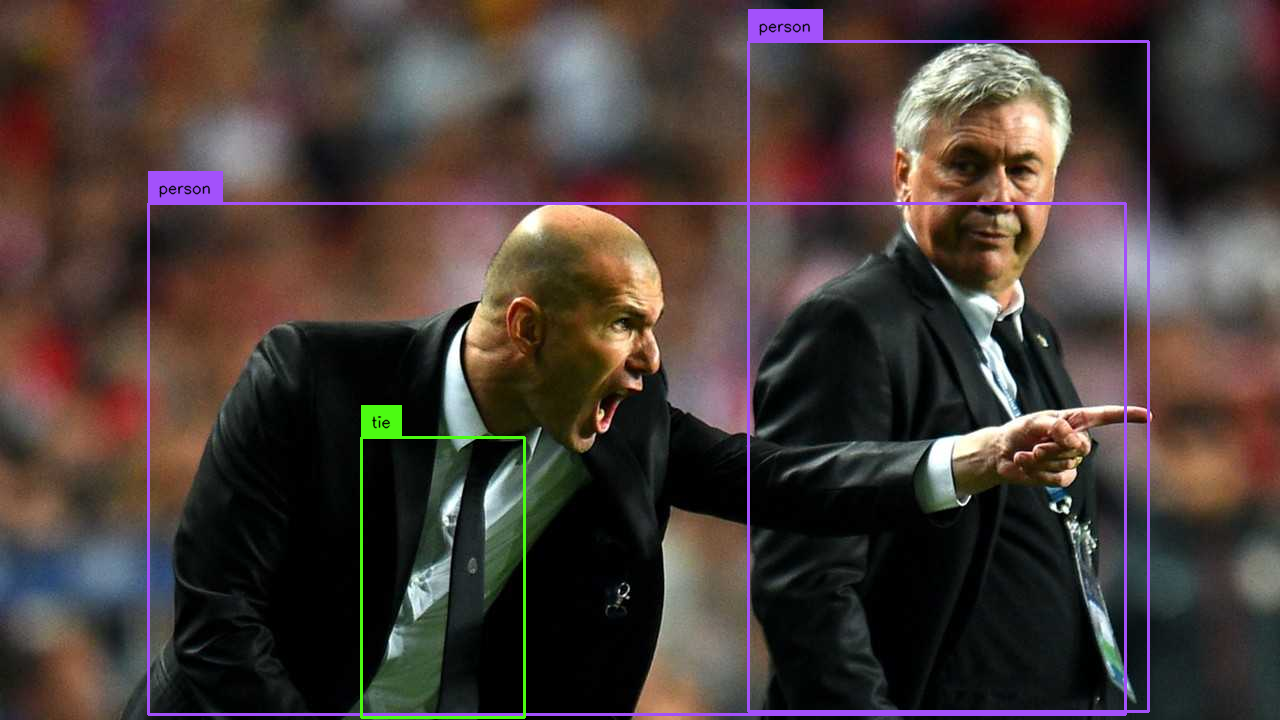

In [8]:
import supervision as sv

image = im1
result = model(im1)[0]  # batch of images

detections = sv.Detections.from_ultralytics(result)
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_color=sv.Color.BLACK)

annotated_image = image.copy()
annotated_image = box_annotator.annotate(annotated_image, detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

#sv.plot_image(annotated_image, size=(10, 10))
display(annotated_image)

Как устроена модель: 

- **Backbone** - это основная часть сети. Для YOLOv5 бекбон спроектирован с использованием CSP-Darknet53 — модификации архитектуры Darknet, использовавшейся в предыдущих версиях.
- **Neck**: Эта часть соединяет backbone и head. В YOLOv5 используются структуры SPPF и New CSP-PAN.
- **Head**: Эта часть отвечает за конечный результат. Она генерирует предсказанные bbox-ы.


У YOLO длинная история. Рассмотрим некоторые основные идеи. 
![alt_text](../../additional_materials/images/yolo_evolution.png)

Мы сегодня рассмотрим основные вещи YOLOv5, попробуем ее и YOLOv11. 
Итак, общая архитектура YOLOv5 показана ниже:
![alt_text](../../additional_materials/images/YOLOv5-1.png).

Какие важные идеи были использованы? 
Первое - SCPNet (Cross Stage Partial Network). Это важная часть, которая довольно долго тянется в YOLO для того, чтобы управлять протеканием градиентов. Чуть раньше перед этим была придумана DenseNet как ультра-версия резнета ( все блоки соединены со всеми), и из нее выросла идея конкатенировать выходы блоков с более поздними. Это было добавлено в YOLO4, показало эффективность и используется в некотором виде до сих пор. 

![alt_text](../../additional_materials/images/yolo_back.png).

Второе - Spatial Pyramid pooling. Этот вид пулинга берет входы с разных этапов прохода по сети и объединяет ыместе конкатенацией, что похволяет находить объекты разных размеров.

![alt_text](../../additional_materials/images/sppf.jfif).

Обучение проводится за один шаг, а не в несколько этапов. В YOLOv5 функция лосса была следующей:
![alt_text](../additional_materials/images/det_loss.svg)

Она содержит: 
- Classes Loss (BCE Loss): Бинарная кросс-энтропия для классификации категорий
- Objectness Loss (BCE Loss): Еще одна кросс-энтропия, которая позволяет определить, есть ли объект в предсказанном bbox-е.
- Location Loss (CIoU Loss): Complete IoU loss, определяет ошибку локализации в гриде
Кроме того, функция потерь взвешивается для разных размеров объектов: $L = w_{big} * L_{big} + w_{medium} * L_{medium} + w_{small} * L_{small} $



Как строятся обучающие датасеты? У YOLO свой формат,описывающий изображения следующим образом: 
Рассмотрим пример картинки: 

![alt_text](../../additional_materials/images/two-persons-tie.avif)

Она содержит два объекта. Каждому из них соответствует bbox и класс. 
Они сохраняются в файл с разметкой вида: 
<img src="../../additional_materials/images/two-persons-tie-1.avif" alt="drawing" width="500"/>

Датасет же организуется так как указано ниже:
```
../datasets/coco128/images/im0.jpg  # image
../datasets/coco128/labels/im0.txt  # label
```
Другой часто использующийся формат датасета - COCO. Пример ниже:
```json
{
    "info": {
        "description": "COCO 2017 Dataset",
        "url": "http://cocodataset.org",
        "version": "1.0",
        "year": 2017,
        "contributor": "COCO Consortium",
        "date_created": "2017/09/01"
    },
    "licenses": [
        {"url": "http://creativecommons.org/licenses/by/2.0/","id": 4,"name": "Attribution License"}
    ],
    "images": [
        {"id": 242287, "license": 4, "coco_url": "http://images.cocodataset.org/val2017/xxxxxxxxxxxx.jpg", "flickr_url": "http://farm3.staticflickr.com/2626/xxxxxxxxxxxx.jpg", "width": 426, "height": 640, "file_name": "xxxxxxxxx.jpg", "date_captured": "2013-11-15 02:41:42"},
        {"id": 245915, "license": 4, "coco_url": "http://images.cocodataset.org/val2017/nnnnnnnnnnnn.jpg", "flickr_url": "http://farm1.staticflickr.com/88/xxxxxxxxxxxx.jpg", "width": 640, "height": 480, "file_name": "nnnnnnnnnn.jpg", "date_captured": "2013-11-18 02:53:27"}
    ],
    "annotations": [
        {"id": 125686, "category_id": 0, "iscrowd": 0, "segmentation": [[164.81, 417.51,......167.55, 410.64]], "image_id": 242287, "area": 42061.80340000001, "bbox": [19.23, 383.18, 314.5, 244.46]},
        {"id": 1409619, "category_id": 0, "iscrowd": 0, "segmentation": [[376.81, 238.8,........382.74, 241.17]], "image_id": 245915, "area": 3556.2197000000015, "bbox": [399, 251, 155, 101]},
        {"id": 1410165, "category_id": 1, "iscrowd": 0, "segmentation": [[486.34, 239.01,..........495.95, 244.39]], "image_id": 245915, "area": 1775.8932499999994, "bbox": [86, 65, 220, 334]}
    ],
    "categories": [
        {"supercategory": "speaker","id": 0,"name": "echo"},
        {"supercategory": "speaker","id": 1,"name": "echo dot"}
    ]
}
```

Как модели обучают? Можно, как обычно в torch, создать датасет и обучить модель, используя кастомные лоссы. Впрочем, в ultralitics есть готовые функции для этого, нужно лишь подготовить датасет.


Загрузим датасет. Это датасет, содержащий объекты и персонажей apex legends. Этот датасет - один из публичных датасетов roboflow, воспользуемся им.

In [9]:
from roboflow import Roboflow
rf = Roboflow(api_key="gBEVJv3dzHvI8Bu5OlHG")
project = rf.workspace("roboflow-100").project("apex-videogame")
version = project.version(2)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to apex-videogame-2 in yolov5pytorch:: 100%|██████████| 7390/7390 [00:00<00:00, 9597.41it/s] 


Дообучим модель. Обучать ее с нуля для нас нет смысла. Попробуем дообучить 2 эпохи.

In [10]:
results = model.train(data="data.yaml", epochs=2, imgsz=640)

Ultralytics 8.3.36 🚀 Python-3.12.7 torch-2.4.1+cu121 CPU (AMD Ryzen 7 6800H with Radeon Graphics)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=data.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

train: Scanning /home/dima/Документы/Першин_Никольская_Нейронные_сети/spbu_deep_learning/datasets/apex-videogame-2/train/labels.cache... 2583 images, 11 backgrounds, 0 corrupt: 100%|██████████| 2583/2583 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /home/dima/Документы/Першин_Никольская_Нейронные_сети/spbu_deep_learning/datasets/apex-videogame-2/valid/labels.cache... 691 images, 1 backgrounds, 0 corrupt: 100%|██████████| 691/691 [00:00<?, ?it/s]

Plotting labels to runs/detect/train/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G       2.11      3.476       1.79         13        640: 100%|██████████| 162/162 [06:38<00:00,  2.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:41<00:00,  1.90s/it]

                   all        691        828      0.438      0.303      0.303      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G      1.591      2.087      1.367         14        640: 100%|██████████| 162/162 [06:28<00:00,  2.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:37<00:00,  1.70s/it]

                   all        691        828      0.553      0.434       0.46      0.227



2 epochs completed in 0.242 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.12.7 torch-2.4.1+cu121 CPU (AMD Ryzen 7 6800H with Radeon Graphics)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 22/22 [00:31<00:00,  1.43s/it]


                   all        691        828      0.549      0.435      0.461      0.227
                avatar        637        704      0.644      0.619      0.645      0.329
                object        112        124      0.454       0.25      0.276      0.126
Speed: 1.0ms preprocess, 39.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


Обратите внимание, как быстро обучается модель. Большой плюс YOLO - ее быстродействие. Результаты обучения сохраняются в файлы, их можно посмотреть после обучения. Посмотрим же. 

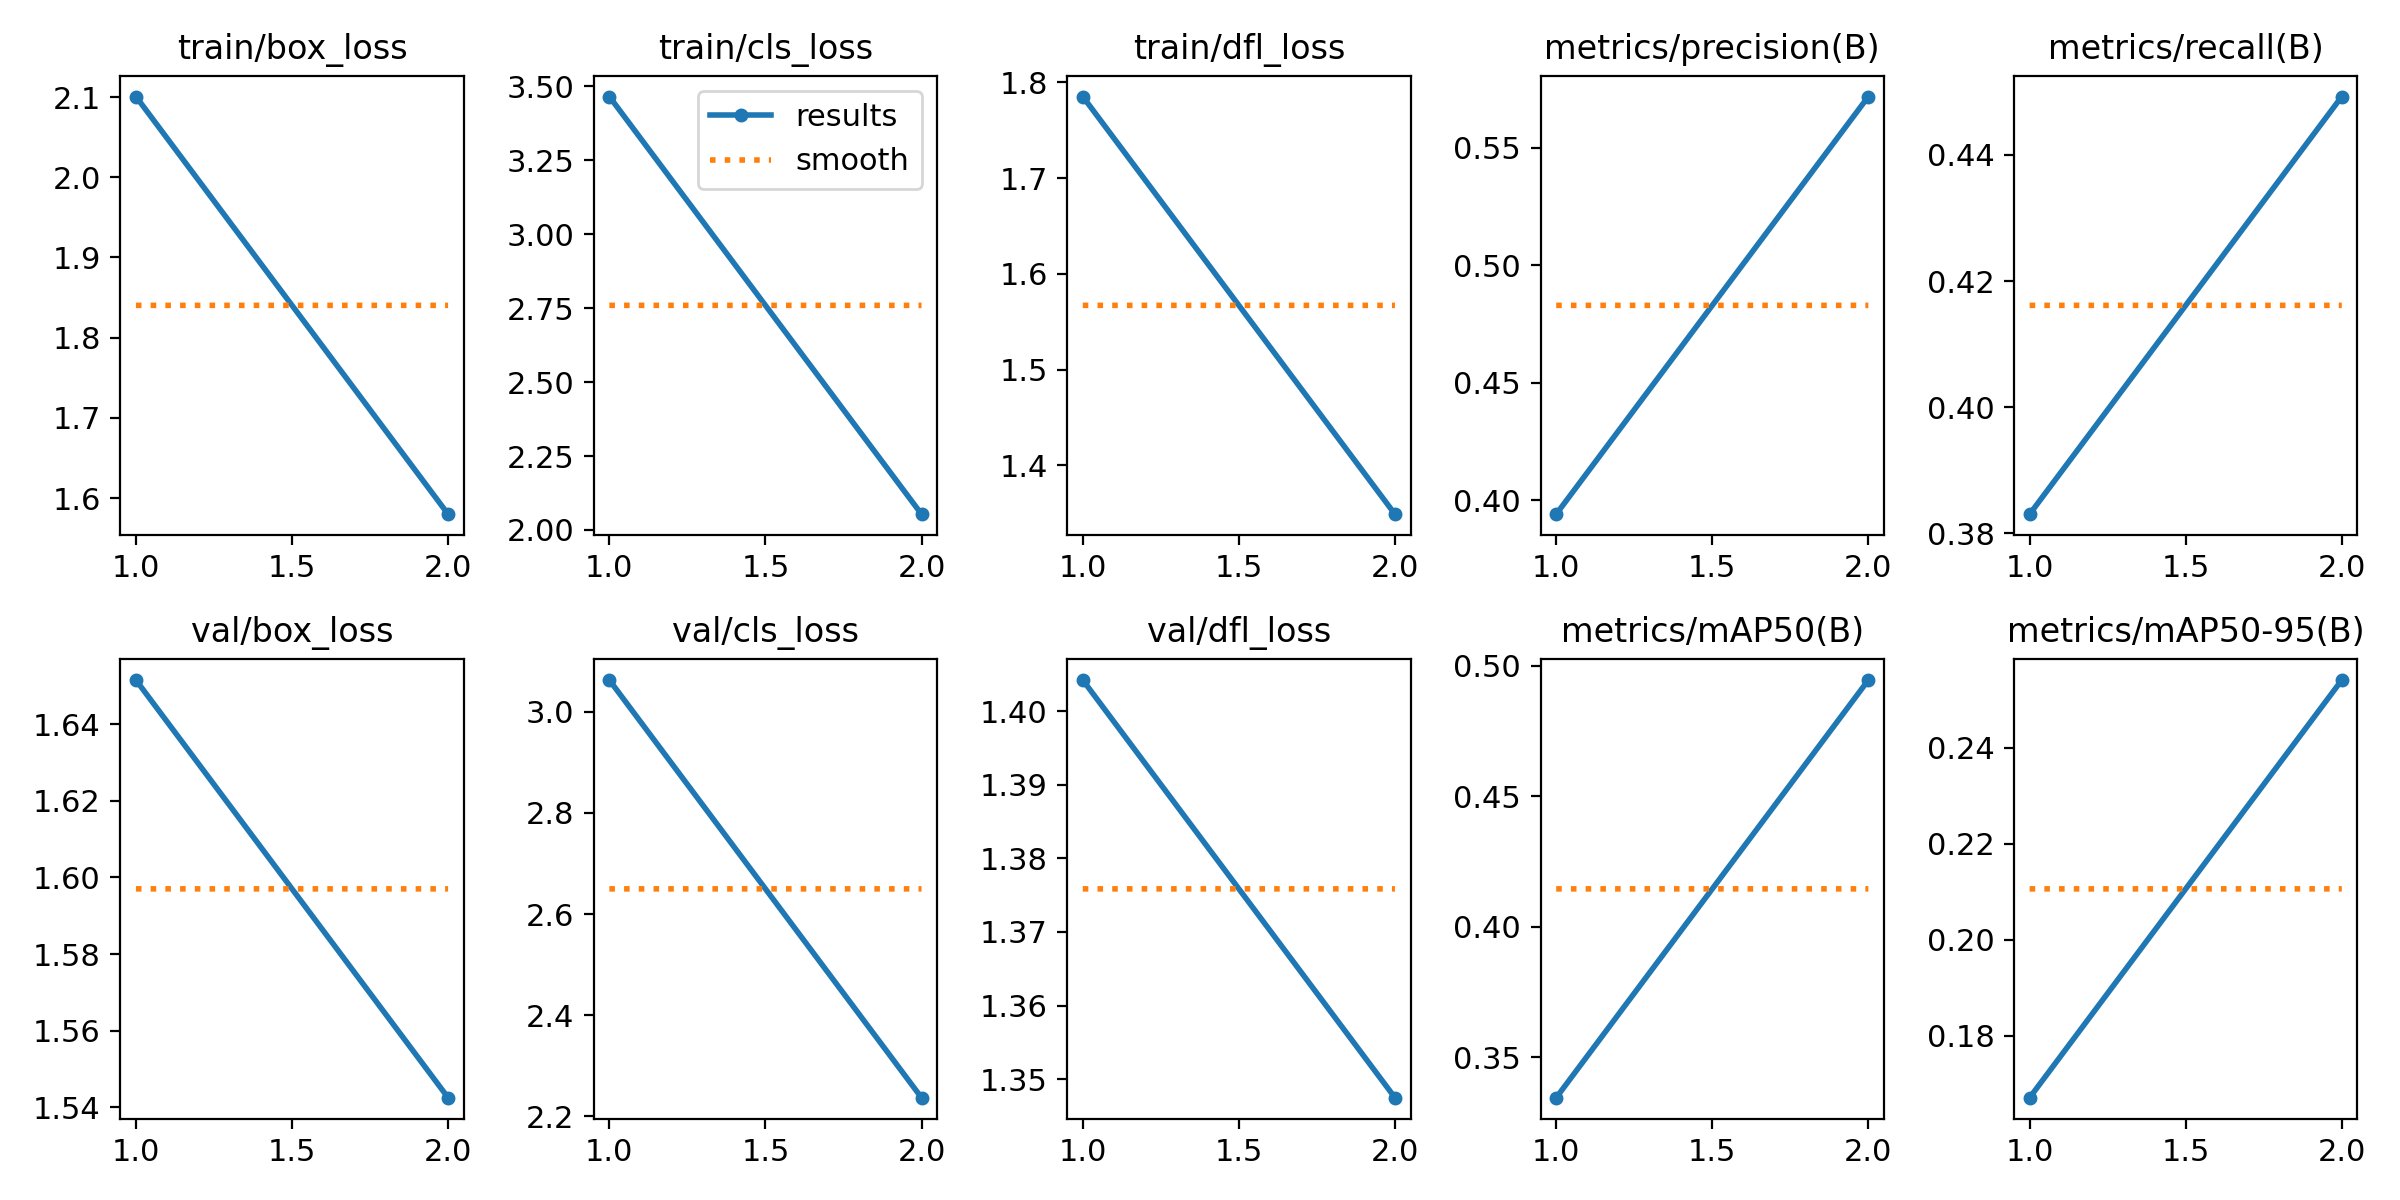

In [11]:
from IPython.display import Image as IPyImage
filename = "./runs/detect/train12/results.png"
IPyImage(filename=filename, width=600)

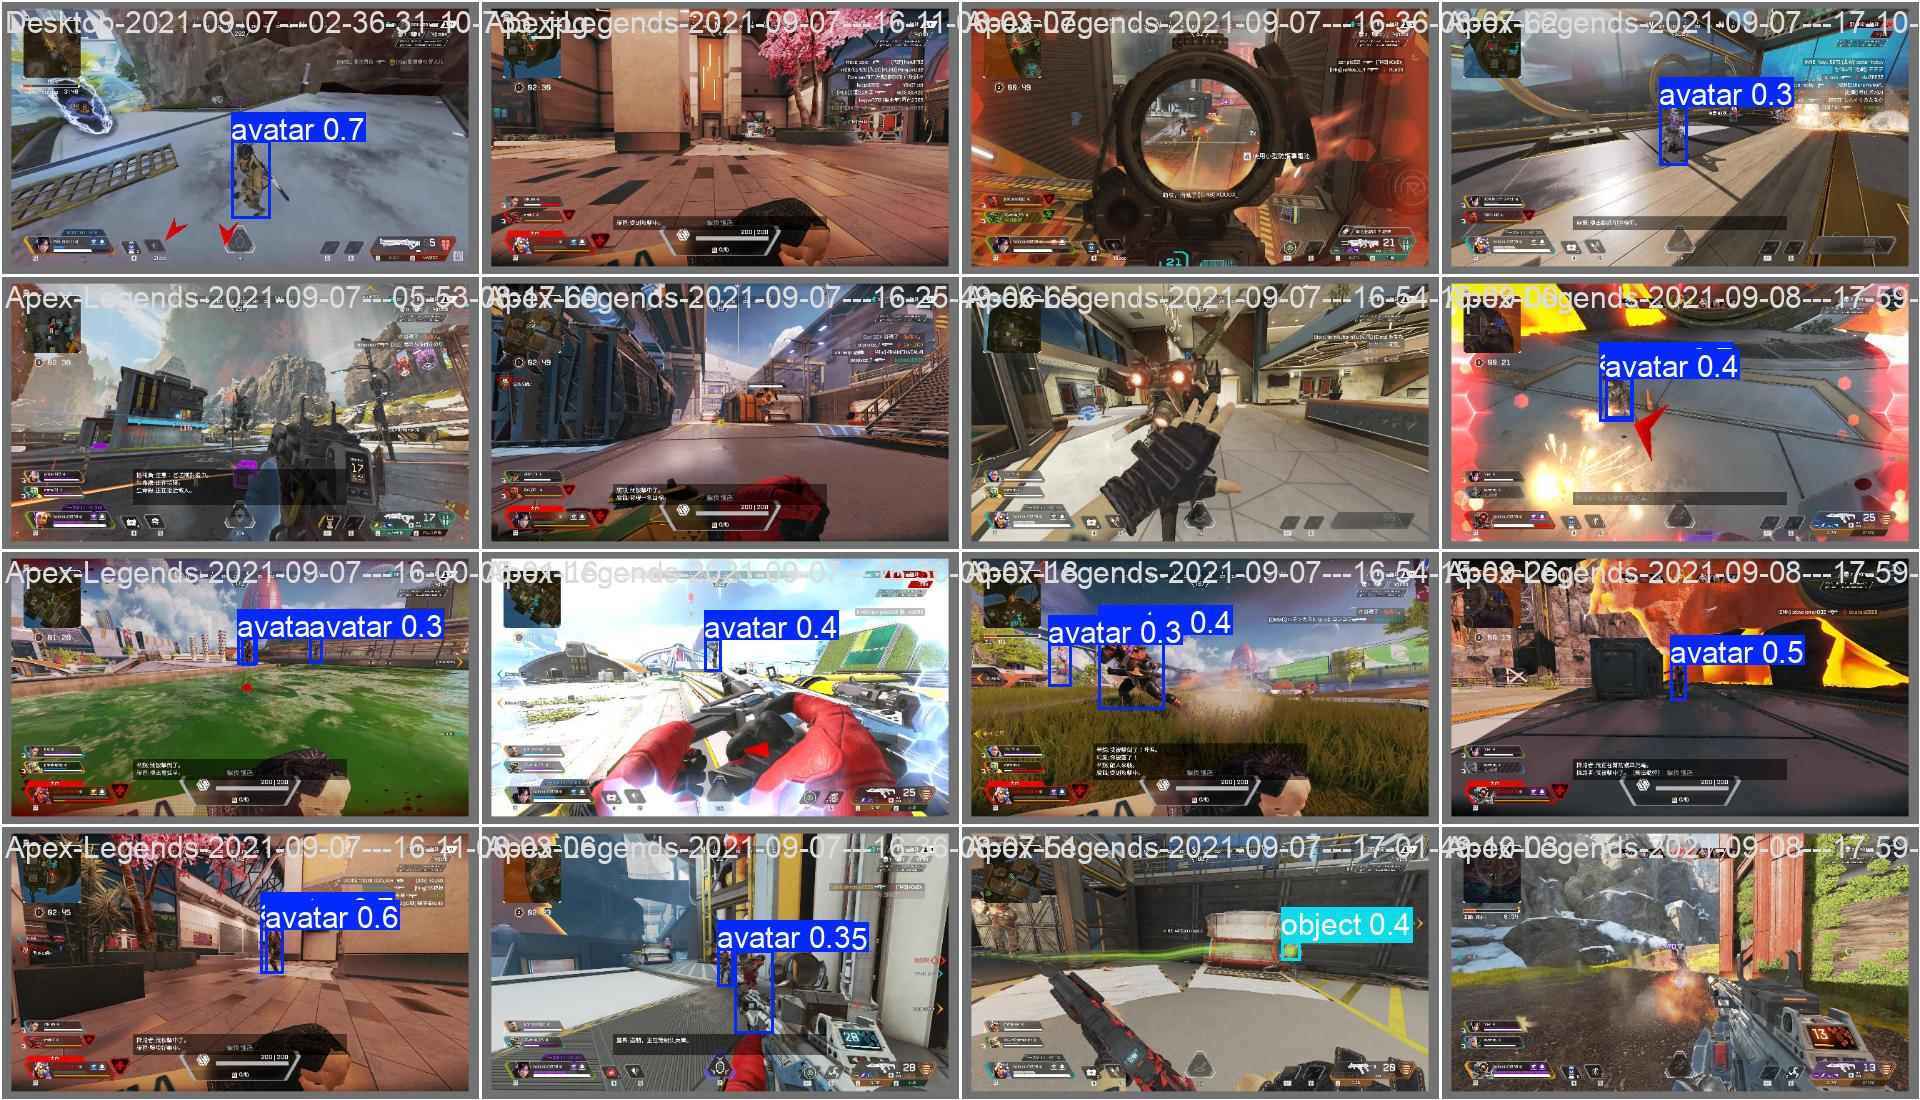

In [12]:

filename = "./runs/detect/train12/val_batch0_pred.jpg"
IPyImage(filename=filename, width=600)

Провалидируем модель: 

In [13]:
!yolo task=detect mode=val model="./runs/detect/train12/weights/best.pt" data=./data.yaml

Ultralytics 8.3.36 🚀 Python-3.12.7 torch-2.4.1+cu121 CPU (AMD Ryzen 7 6800H with Radeon Graphics)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs
val: Scanning /home/dima/Документы/Першин_Никольская_Нейронные_сети/spbu_deep_le
                 Class     Images  Instances      Box(P          R      mAP50  m
                   all        691        828      0.585      0.441      0.494      0.253
                avatar        637        704      0.653      0.624       0.67      0.353
                object        112        124      0.516      0.258      0.319      0.154
Speed: 1.2ms preprocess, 44.0ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val2
💡 Learn more at https://docs.ultralytics.com/modes/val


Задание: сделайте инференс модели на тестовых данных. Напишите функцию инференса и вывод результата

In [14]:
import cv2
import os
images = [f for f in os.listdir("../../datasets/apex-videogame-2/test/images/") if f.endswith((".jpg", ".png", ".jpeg"))]

In [15]:
images[0]

'Apex-Legends-2021-09-07---16-36-08-07-310_jpg.rf.db602986cbc4df39a3a2e63775ddbbec.jpg'

In [79]:
def get_labels(label_file, img_width, img_height):
    gt_boxes = []
    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            for line in f:
                data = line.strip().split()
                cls, x_center, y_center, width, height = map(float, data)
                x1 = int((x_center - width  / 2) * img_width)
                y1 = int((y_center - height / 2) * img_height)
                x2 = int((x_center + width  / 2) * img_width)
                y2 = int((y_center + height / 2) * img_height)
                gt_boxes.append((int(cls), x1, y1, x2, y2))
    return gt_boxes

def draw_labels(img, results, gt_box):
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    for result in results:
        for box in result.boxes:
            x1, y1, x2, y2 = map(int, box.xyxy[0])  # координаты
            cls = int(box.cls[0])                   # класс
            conf = box.conf[0]                      # вероятность
            label = f"{cls}: {conf:.2f}"            # метка

            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    for result in gt_box:
        print(result)
        _, x1, y1, x2, y2 = result  # координаты

        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

In [ ]:
import time

input_path= "../../datasets/apex-videogame-2/test/"
input_lable_path = "labels/"
input_img_path = "images/"
output_img_path = "double_labels/"

for image in images:
    image_file = input_path + input_img_path + image
    lable_file = input_path + input_lable_path +  image.rsplit(sep=".", maxsplit=1)[0] + ".txt"
    print(lable_file)
    out_img_file = input_path + output_img_path + os.path.splitext(image)[0] + "_out." + os.path.splitext(image)[-1]

    img = cv2.imread(image_file)
    print(img.shape)
    #print(img)

    img_height, img_width, _ = img.shape

    gt_boxes = get_labels(lable_file, img_width, img_height)
    print(gt_boxes)

    results = model(image_file)

    draw_labels(img, results, gt_boxes)
    
    plt.imsave(out_img_file, img)

../../datasets/apex-videogame-2/test/labels/Apex-Legends-2021-09-07---16-36-08-07-310_jpg.rf.db602986cbc4df39a3a2e63775ddbbec.txt
(1080, 1920, 3)
[(0, 972, 497, 1025, 602)]

image 1/1 /home/dima/Документы/Першин_Никольская_Нейронные_сети/spbu_deep_learning/notebooks/09.11/../../datasets/apex-videogame-2/test/images/Apex-Legends-2021-09-07---16-36-08-07-310_jpg.rf.db602986cbc4df39a3a2e63775ddbbec.jpg: 384x640 1 clock, 36.0ms
Speed: 1.6ms preprocess, 36.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)
(0, 972, 497, 1025, 602)
../../datasets/apex-videogame-2/test/labels/934_png_jpg.rf.d7076e5dd7708d6b26341f6a954a2648.txt
(640, 640, 3)
[(0, 210, 275, 263, 379)]

image 1/1 /home/dima/Документы/Першин_Никольская_Нейронные_сети/spbu_deep_learning/notebooks/09.11/../../datasets/apex-videogame-2/test/images/934_png_jpg.rf.d7076e5dd7708d6b26341f6a954a2648.jpg: 640x640 1 person, 38.5ms
Speed: 1.1ms preprocess, 38.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 

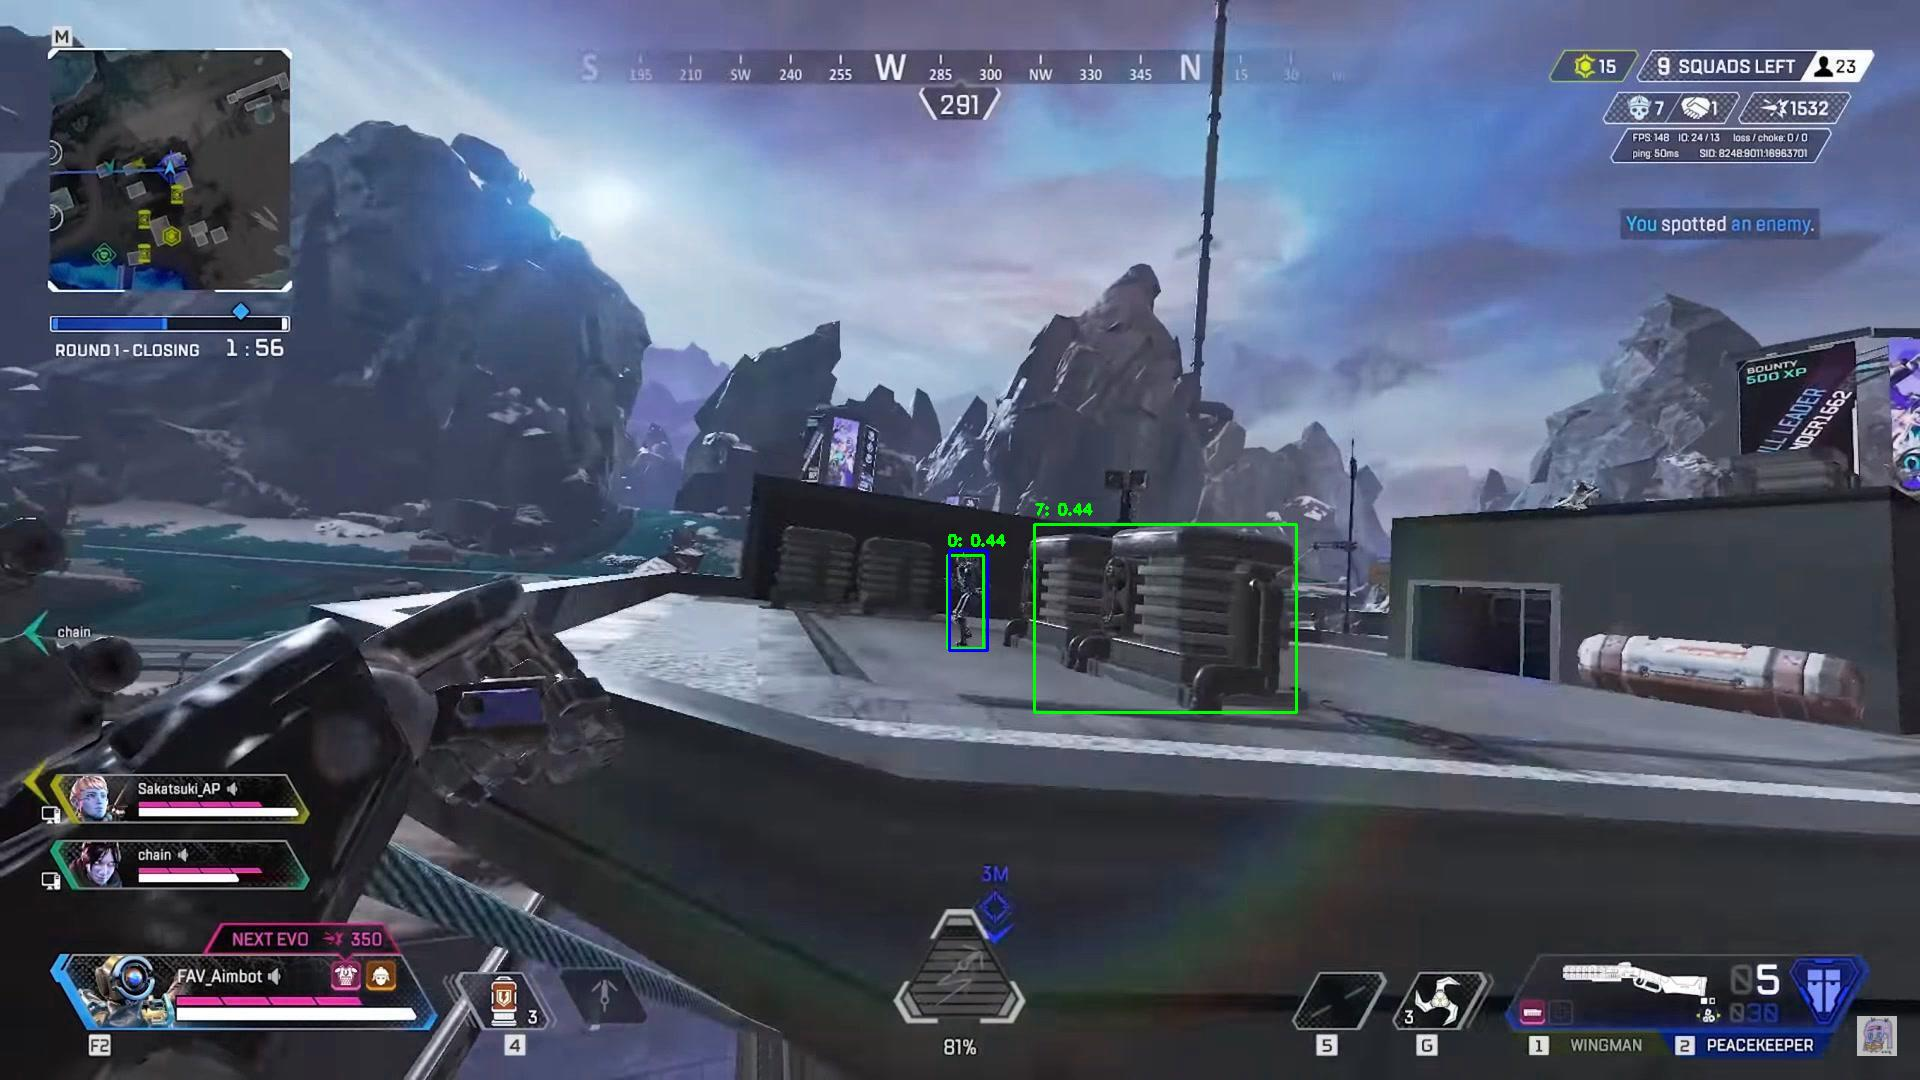

In [82]:
images_detected = [f for f in os.listdir("../../datasets/apex-videogame-2/test/double_labels/") if f.endswith((".jpg", ".png", ".jpeg"))]
Image("../../datasets/apex-videogame-2/test/double_labels/" + images_detected[10])